# 3_likelihoods

In [1]:
import numpy as np
from scipy.stats import uniform,beta,norm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
"""
Cut out a representative model from our grid to use as a makeshift hare
"""
df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

# For now, retrieve representative model point from the grid for hare
# Inrementally choose highest peak in histogram until we get to age, at which point just choose nice value (went for close to 4Gyr)
df_trim = df[df["initial_mass"] == 1.12]
df_trim = df_trim[df_trim["initial_Zinit"] == df_trim["initial_Zinit"].unique()[32]]
df_trim = df_trim[df_trim["initial_MLT"] == df_trim["initial_MLT"].unique()[1]]

model = df_trim[df_trim["star_age"] == df_trim["star_age"].iloc[(np.abs(df_trim["star_age"]-3)).argmin()]]

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'surface_Z']+[f'nu_0_{i+1}' for i in range(14,25)]

model_inps = model[inputs]
model_outs = model[outputs]

model

initial_mass  initial_Zinit  initial_Yinit  initial_MLT  star_age  \
6246893          1.12        0.02649           0.24          2.5  3.013309   

           radius  luminosity  effective_T  surface_Z      nu_0_4  ...  \
6246893  0.984237    0.906909  5681.598567    0.02649  730.058814  ...   

         log_nu_0_31_std  log_nu_0_32_std  log_nu_0_33_std  log_nu_0_34_std  \
6246893         0.882504         0.883278         0.884565         0.886251   

         log_nu_0_35_std  log_nu_0_36_std  log_nu_0_37_std  log_nu_0_38_std  \
6246893         0.888237         0.890298         0.891467         0.891309   

         log_nu_0_39_std  log_nu_0_40_std  
6246893         0.891636         0.890649  

[1 rows x 184 columns]

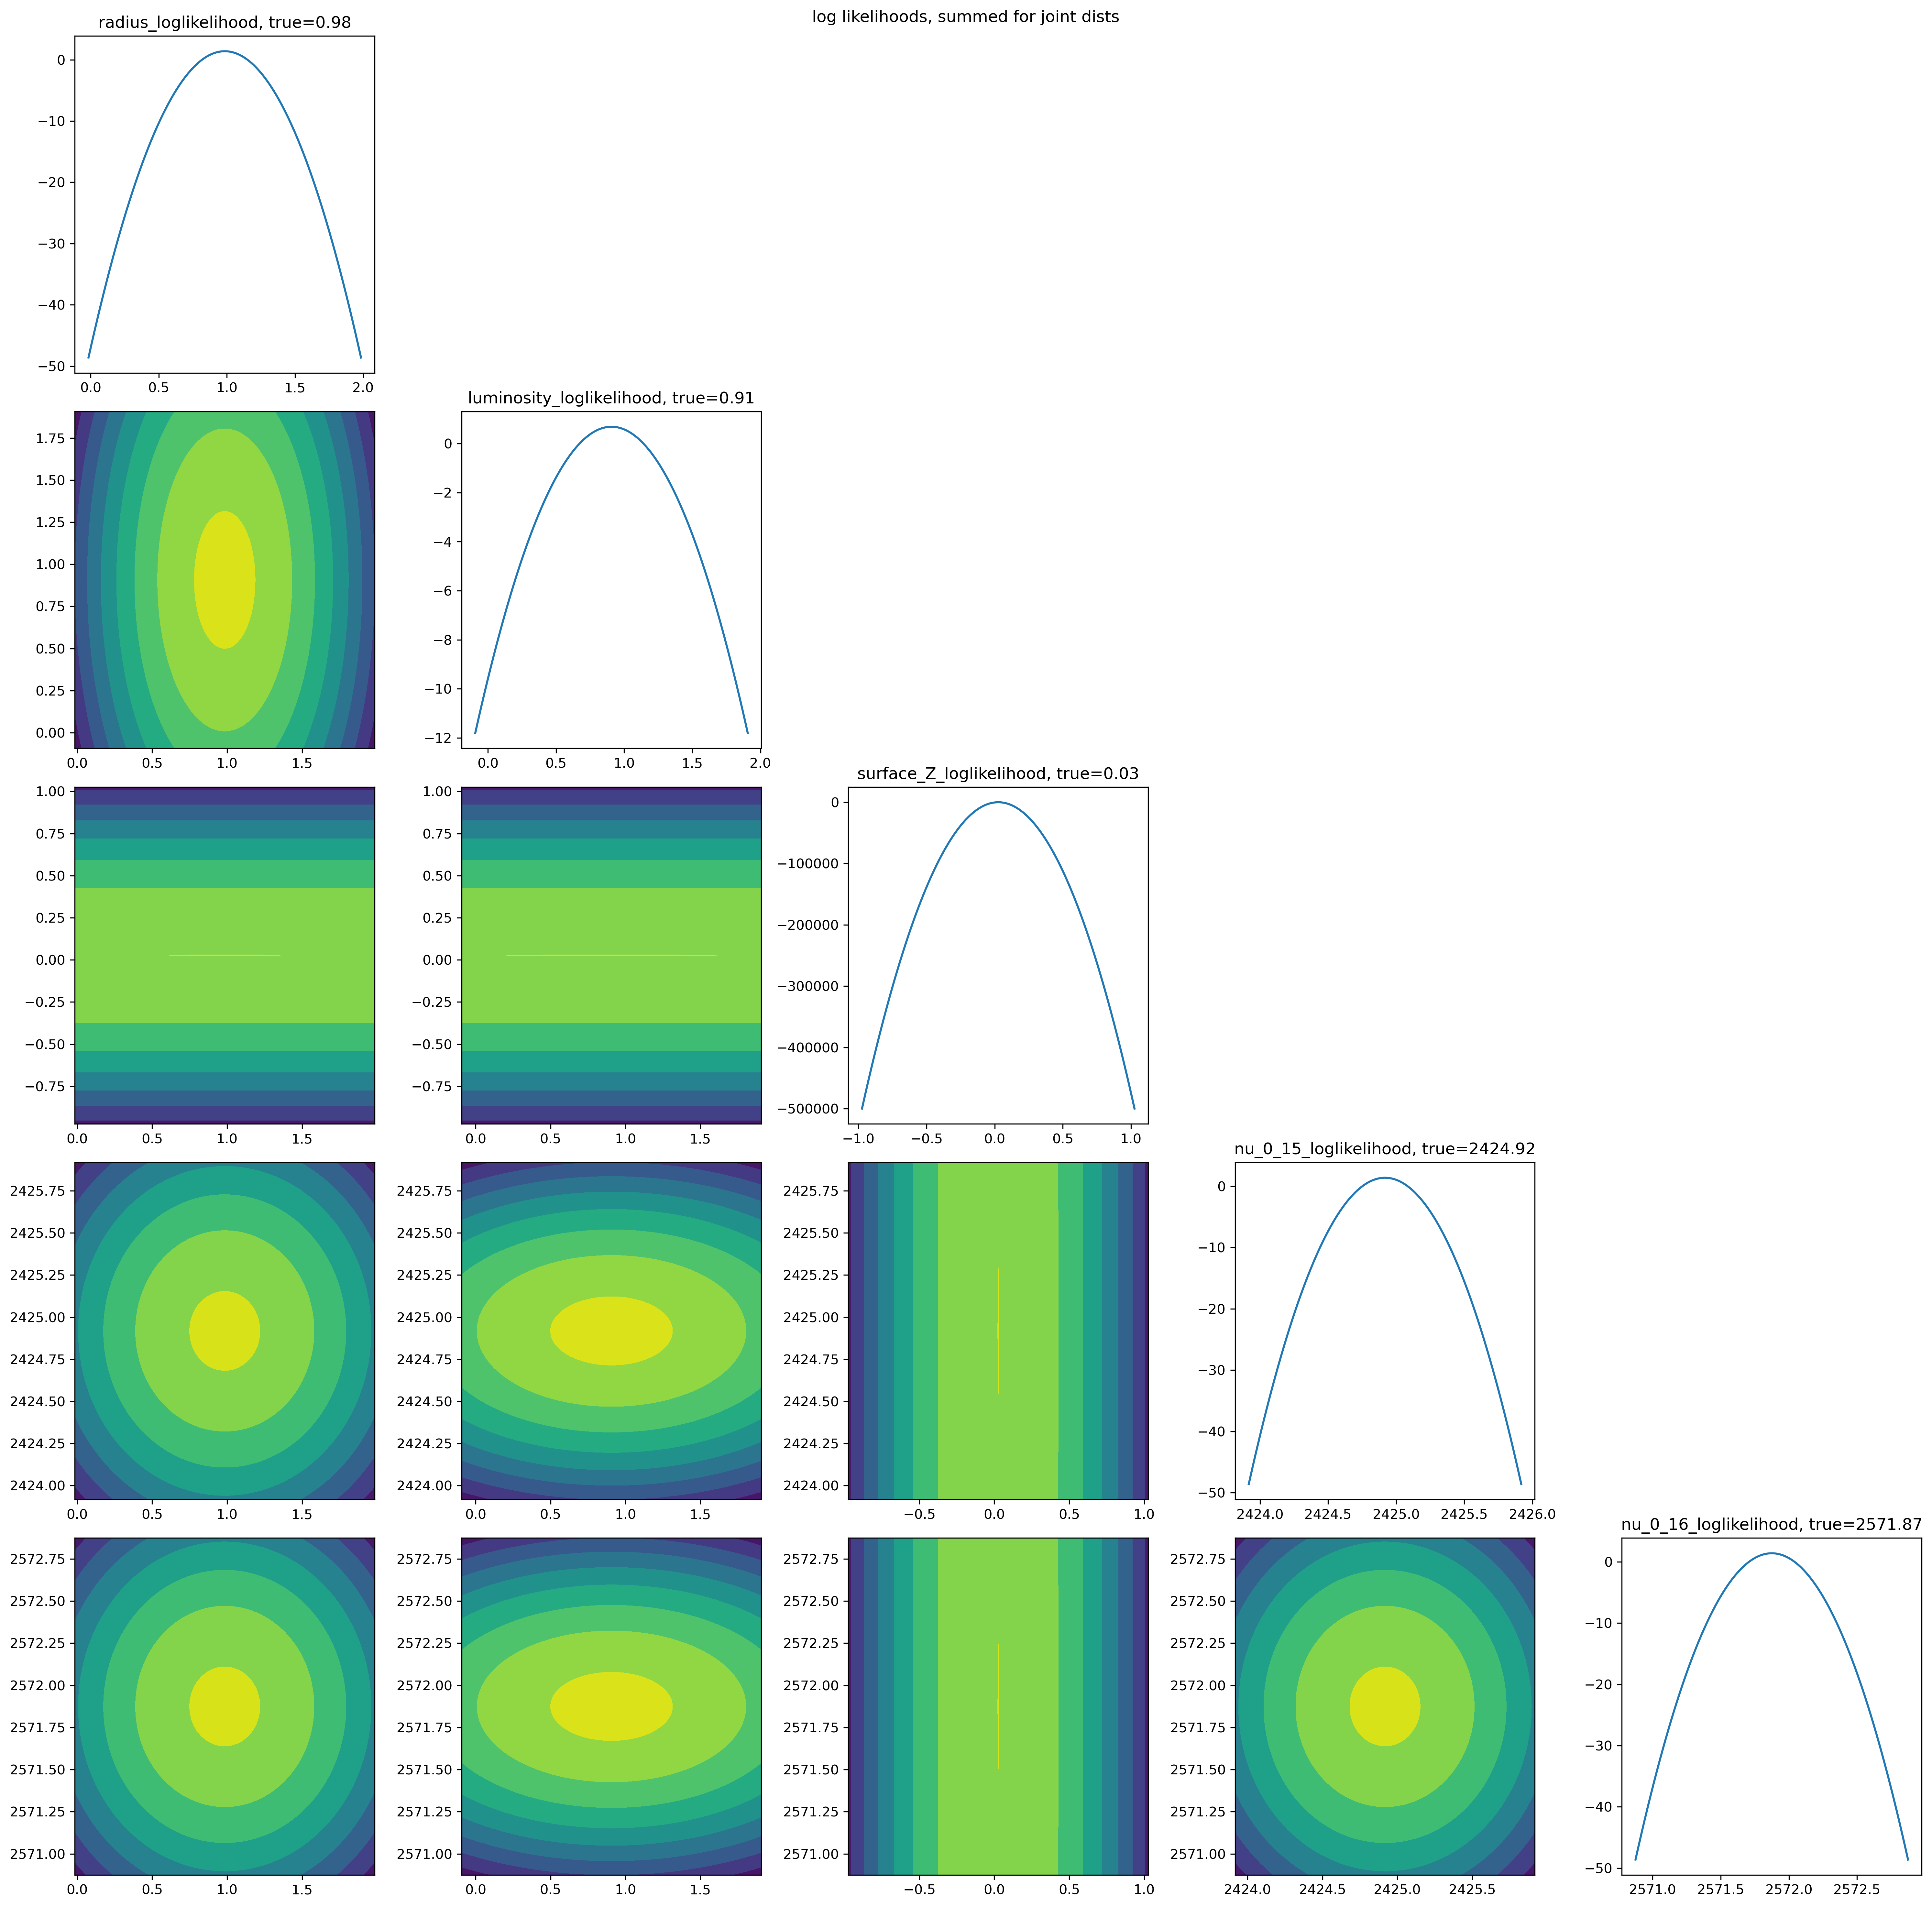

In [3]:
class Likelihood:
    def __init__(self, obs, obs_unc):
        """
        Define mean and standard deviation to create normal distributions for likelihoods
        """
        self.obs = obs
        self.obs_unc = obs_unc
        self.likelihood = norm(loc=obs,scale=obs_unc)

    def pdf(self, x):
        """
        Create pdf of likelihood (normal) with mean and std of obs and obs_unc, respectively
        """
        return self.likelihood.pdf(x)


    def logpdf(self, x):
        """
        Create logpdf of likelihood
        """
        return self.likelihood.logpdf(x)


# For now, simulate some representative likelihoods using just obs noise
obs_uncs = [0.1, 0.2, 0.001, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

likelihood_dict = {}
for i in range(len(obs_uncs)):
    likelihood_dict[outputs[i] + "_likelihood"] = Likelihood(obs=model_outs.values.flatten()[i],obs_unc=obs_uncs[i])

N = 5

subplot_indices = []

for i in range(N):
    subplot_indices.append([i*N + k  for k in range(1,i+2)])

output_combos = []

for output_x in outputs[:N]:
    for output_y in outputs[:N]:
        output_combos.append([output_x, output_y])

plt.figure(figsize=(20,20), dpi=300, layout="tight")
for subplot_index_row in subplot_indices:
    for subplot_index in subplot_index_row:
        plt.subplot(N,N,subplot_index)
        output_combo = output_combos[subplot_index-1]
        if output_combo[0] == output_combo[1]:
            x = np.linspace(model_outs[output_combo[0]].values[0]-1, model_outs[output_combo[0]].values[0]+1, 1000)
            likelihood = likelihood_dict[output_combo[0] + "_likelihood"]
            y = likelihood.logpdf(x)
            plt.plot(x,y)
            plt.title(output_combo[0] + f"_loglikelihood, true={model_outs[output_combo[0]].values[0]:.2f}")
        else:
            x = np.linspace(model_outs[output_combo[1]].values[0]-1, model_outs[output_combo[1]].values[0]+1, 1000)
            x_likelihood = likelihood_dict[output_combo[1] + "_likelihood"]
            y = np.linspace(model_outs[output_combo[0]].values[0]-1, model_outs[output_combo[0]].values[0]+1, 1000)
            y_likelihood = likelihood_dict[output_combo[0] + "_likelihood"]
            xs,ys = np.meshgrid(x_likelihood.logpdf(x), y_likelihood.logpdf(y))
            zs = xs+ys
            h = plt.contourf(x,y,zs)
            #plt.colorbar()

plt.suptitle("log likelihoods, summed for joint dists")
#plt.savefig("figs/summed_log_likelihoods.png", transparent="false", facecolor="white")
plt.show()